In [1]:
# from google.colab import drive

In [2]:
# drive.mount("/content/drive")

Mounted at /content/drive


In [56]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [57]:
# setting default constants
IMAGE_SIZE = 224
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 10

In [58]:
# loading the data in the tf input pipeline
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6468 files belonging to 4 classes.


In [59]:
class_names = dataset.class_names
class_names

['Not_Disease', 'potato_early_blight', 'potato_healthy', 'potato_late_blight']

In [60]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 224, 224, 3)
[3 1 2 1 3 3 1 1 3 3 1 1 2 1 3 1]


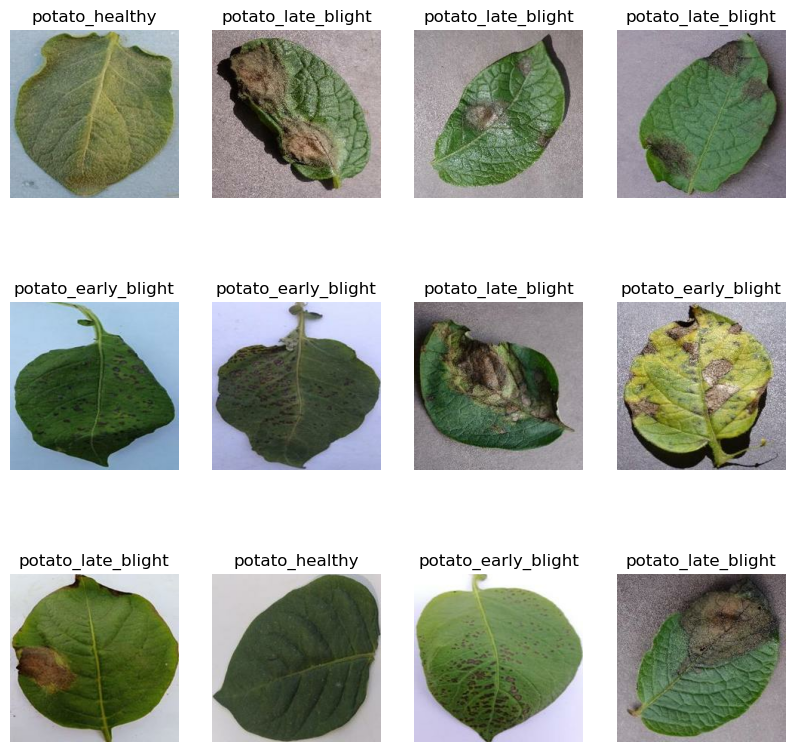

In [61]:
# viusualising the data
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [62]:
# creating the train, test, and validation split function
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [63]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [64]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

283
60
62


In [65]:
# caching and prefetching for training optimization
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [66]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [67]:
# data augmentation to increase input data
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [68]:
base_model = MobileNetV3Large(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
                         include_top=False,
                         weights='imagenet')

In [69]:
base_model.trainable = False

In [70]:
# Create the model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

# Implementing the architecture of MobileNetV3.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
preds = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

model.build(input_shape=input_shape)

In [71]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 224, 224, 3)          0         ['input_6[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_7[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                  

 expanded_conv_2/depthwise   (None, 56, 56, 72)           648       ['re_lu_121[0][0]']           
 (DepthwiseConv2D)                                                                                
                                                                                                  
 expanded_conv_2/depthwise/  (None, 56, 56, 72)           288       ['expanded_conv_2/depthwise[0]
 BatchNorm (BatchNormalizat                                         [0]']                         
 ion)                                                                                             
                                                                                                  
 re_lu_122 (ReLU)            (None, 56, 56, 72)           0         ['expanded_conv_2/depthwise/Ba
                                                                    tchNorm[0][0]']               
                                                                                                  
 expanded_

 re_lu_126 (ReLU)            (None, 28, 28, 120)          0         ['expanded_conv_4/expand/Batch
                                                                    Norm[0][0]']                  
                                                                                                  
 expanded_conv_4/depthwise   (None, 28, 28, 120)          3000      ['re_lu_126[0][0]']           
 (DepthwiseConv2D)                                                                                
                                                                                                  
 expanded_conv_4/depthwise/  (None, 28, 28, 120)          480       ['expanded_conv_4/depthwise[0]
 BatchNorm (BatchNormalizat                                         [0]']                         
 ion)                                                                                             
                                                                                                  
 re_lu_127

 )                                                                  te/Conv_1[0][0]']             
                                                                                                  
 re_lu_131 (ReLU)            (None, 1, 1, 120)            0         ['tf.math.add_87[0][0]']      
                                                                                                  
 tf.math.multiply_87 (TFOpL  (None, 1, 1, 120)            0         ['re_lu_131[0][0]']           
 ambda)                                                                                           
                                                                                                  
 expanded_conv_5/squeeze_ex  (None, 28, 28, 120)          0         ['re_lu_130[0][0]',           
 cite/Mul (Multiply)                                                 'tf.math.multiply_87[0][0]'] 
                                                                                                  
 expanded_

                                                                                                  
 multiply_63 (Multiply)      (None, 14, 14, 200)          0         ['expanded_conv_7/expand/Batch
                                                                    Norm[0][0]',                  
                                                                     'tf.math.multiply_90[0][0]'] 
                                                                                                  
 expanded_conv_7/depthwise   (None, 14, 14, 200)          1800      ['multiply_63[0][0]']         
 (DepthwiseConv2D)                                                                                
                                                                                                  
 expanded_conv_7/depthwise/  (None, 14, 14, 200)          800       ['expanded_conv_7/depthwise[0]
 BatchNorm (BatchNormalizat                                         [0]']                         
 ion)     

                                                                    hNorm[0][0]']                 
                                                                                                  
 expanded_conv_9/expand (Co  (None, 14, 14, 184)          14720     ['expanded_conv_8/Add[0][0]'] 
 nv2D)                                                                                            
                                                                                                  
 expanded_conv_9/expand/Bat  (None, 14, 14, 184)          736       ['expanded_conv_9/expand[0][0]
 chNorm (BatchNormalization                                         ']                            
 )                                                                                                
                                                                                                  
 tf.math.add_94 (TFOpLambda  (None, 14, 14, 184)          0         ['expanded_conv_9/expand/Batch
 )        

 ambda)                                                                                           
                                                                                                  
 multiply_70 (Multiply)      (None, 14, 14, 480)          0         ['expanded_conv_10/depthwise/B
                                                                    atchNorm[0][0]',              
                                                                     'tf.math.multiply_97[0][0]'] 
                                                                                                  
 expanded_conv_10/squeeze_e  (None, 1, 1, 480)            0         ['multiply_70[0][0]']         
 xcite/AvgPool (GlobalAvera                                                                       
 gePooling2D)                                                                                     
                                                                                                  
 expanded_

 xcite/Relu (ReLU)                                                  ite/Conv[0][0]']              
                                                                                                  
 expanded_conv_11/squeeze_e  (None, 1, 1, 672)            113568    ['expanded_conv_11/squeeze_exc
 xcite/Conv_1 (Conv2D)                                              ite/Relu[0][0]']              
                                                                                                  
 tf.math.add_101 (TFOpLambd  (None, 1, 1, 672)            0         ['expanded_conv_11/squeeze_exc
 a)                                                                 ite/Conv_1[0][0]']            
                                                                                                  
 re_lu_145 (ReLU)            (None, 1, 1, 672)            0         ['tf.math.add_101[0][0]']     
                                                                                                  
 tf.math.m

 a)                                                                 ite/Conv_1[0][0]']            
                                                                                                  
 re_lu_148 (ReLU)            (None, 1, 1, 672)            0         ['tf.math.add_104[0][0]']     
                                                                                                  
 tf.math.multiply_104 (TFOp  (None, 1, 1, 672)            0         ['re_lu_148[0][0]']           
 Lambda)                                                                                          
                                                                                                  
 expanded_conv_12/squeeze_e  (None, 7, 7, 672)            0         ['multiply_74[0][0]',         
 xcite/Mul (Multiply)                                                'tf.math.multiply_104[0][0]']
                                                                                                  
 expanded_

 atchNorm (BatchNormalizati                                         0]']                          
 on)                                                                                              
                                                                                                  
 expanded_conv_13/Add (Add)  (None, 7, 7, 160)            0         ['expanded_conv_12/project/Bat
                                                                    chNorm[0][0]',                
                                                                     'expanded_conv_13/project/Bat
                                                                    chNorm[0][0]']                
                                                                                                  
 expanded_conv_14/expand (C  (None, 7, 7, 960)            153600    ['expanded_conv_13/Add[0][0]']
 onv2D)                                                                                           
          

 Conv_1/BatchNorm (BatchNor  (None, 7, 7, 960)            3840      ['Conv_1[0][0]']              
 malization)                                                                                      
                                                                                                  
 tf.math.add_111 (TFOpLambd  (None, 7, 7, 960)            0         ['Conv_1/BatchNorm[0][0]']    
 a)                                                                                               
                                                                                                  
 re_lu_155 (ReLU)            (None, 7, 7, 960)            0         ['tf.math.add_111[0][0]']     
                                                                                                  
 tf.math.multiply_111 (TFOp  (None, 7, 7, 960)            0         ['re_lu_155[0][0]']           
 Lambda)                                                                                          
          

In [72]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [73]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
283/283 [==============================] - 123s 384ms/step - loss: 0.1824 - accuracy: 0.9342 - val_loss: 0.0522 - val_accuracy: 0.9884
Epoch 2/10
283/283 [==============================] - 97s 344ms/step - loss: 0.0714 - accuracy: 0.9739 - val_loss: 0.0796 - val_accuracy: 0.9705
Epoch 3/10
283/283 [==============================] - 94s 334ms/step - loss: 0.0559 - accuracy: 0.9803 - val_loss: 0.0770 - val_accuracy: 0.9694
Epoch 4/10
283/283 [==============================] - 102s 362ms/step - loss: 0.0459 - accuracy: 0.9849 - val_loss: 0.0229 - val_accuracy: 0.9916
Epoch 5/10
283/283 [==============================] - 105s 370ms/step - loss: 0.0330 - accuracy: 0.9876 - val_loss: 0.0456 - val_accuracy: 0.9884
Epoch 6/10
283/283 [==============================] - 108s 380ms/step - loss: 0.0273 - accuracy: 0.9911 - val_loss: 0.0696 - val_accuracy: 0.9789
Epoch 7/10
283/283 [==============================] - 106s 376ms/step - loss: 0.0244 - accuracy: 0.9911 - val_loss: 0.0688 - v

In [75]:
model.save("C:\\Users\\muiru\\blight-buster\\model.h5")

C:\Users\muiru\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [76]:
model.save("C:\\Users\\muiru\\blight-buster\\model.h5")

In [77]:
scores = model.evaluate(test_ds)

62/62 [==============================] - 30s 297ms/step - loss: 0.0176 - accuracy: 0.9919


In [78]:
scores

[0.017631204798817635, 0.9919354915618896]

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

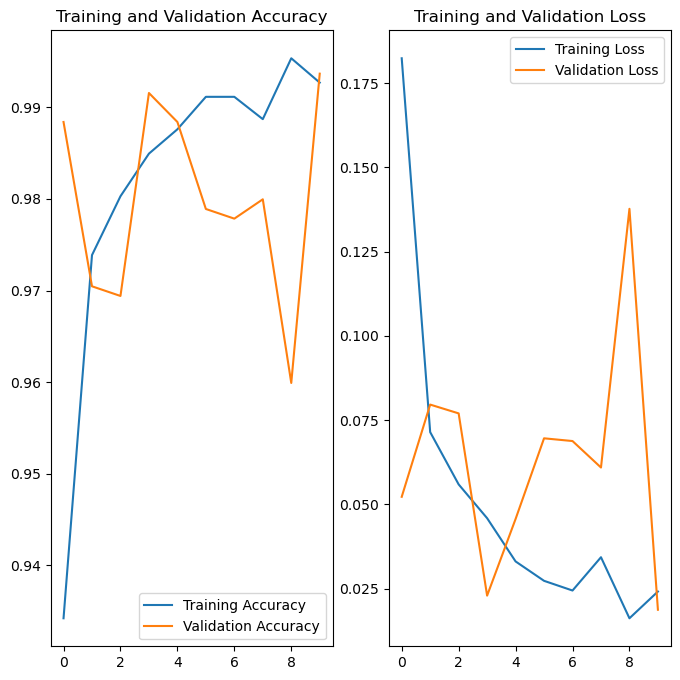

In [80]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
actuallabel:  potato_early_blight
1/1 [==============================] - 2s 2s/step
predicted label:  potato_healthy


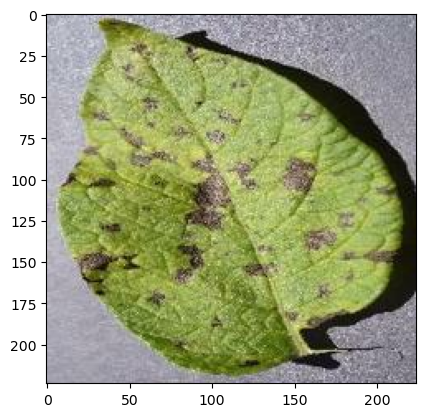

In [81]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [93]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[tf.argmax(predictions[0]).numpy()]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 54ms/step


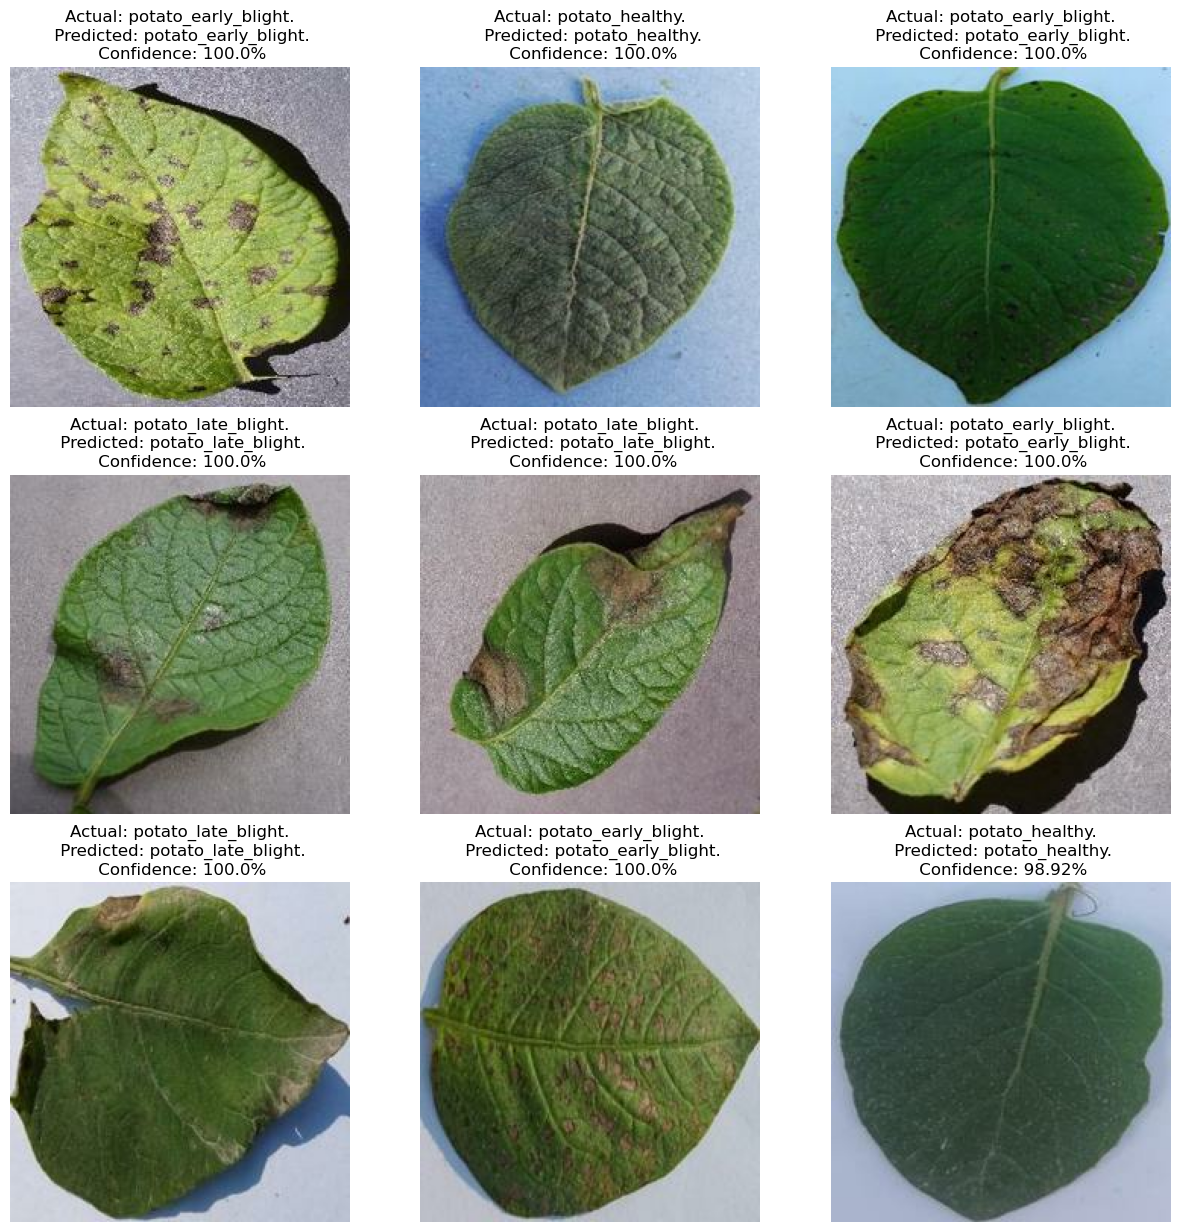

In [94]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}.\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")